In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
# import data and create separate dataframes

nba_rookie_data = pd.read_csv("C:/Users/jho/Desktop/data_science/nba_rookie_data.csv")

# players who have played for at least 5 years
players_yes = nba_rookie_data[nba_rookie_data['TARGET_5Yrs'] == 1]

# players who have not played for at least 5 years
players_no = nba_rookie_data[nba_rookie_data['TARGET_5Yrs'] == 0]
players_no = players_no[players_no['Year Drafted'] <= 2012]

# young players who have not yet been in the league for five years
players_new = nba_rookie_data[nba_rookie_data['Year Drafted'] > 2012]

As we saw in my data story and inferential statistics iPython notebooks, the two set of players (those who played for 5 years and those who did not) are statistically different groups of players based on their rookie year stats. 

The most important stats in determining any players's success are their efficiency, games played, and minutes per game. Efficiency per game is calculated as an average of total games played by combining points, rebounds, assists, steals, and blocks, while subtracting missed shots and turnovers. Minutes per game (out of 48) and games played (out of 82) tell us if the player was talented enough to earn more time on the basketball court. 

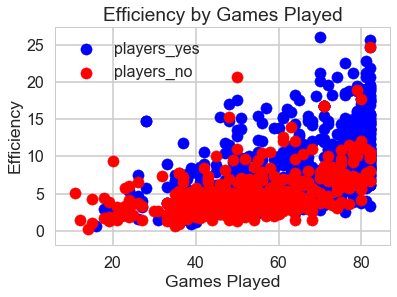

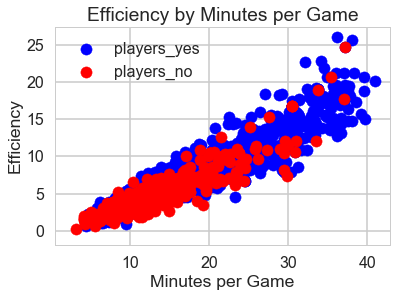

In [3]:
# scatter plots for efficiency by games played and minutes per game

plt.scatter(players_yes['GP'], players_yes['EFF'], color='b')
plt.scatter(players_no['GP'], players_no['EFF'], color='r')
plt.xlabel("Games Played")
plt.ylabel("Efficiency")
plt.title("Efficiency by Games Played")
plt.legend(("players_yes", "players_no"))
plt.show()

plt.scatter(players_yes['MIN'], players_yes['EFF'], color='b')
plt.scatter(players_no['MIN'], players_no['EFF'], color='r')
plt.xlabel("Minutes per Game")
plt.ylabel("Efficiency")
plt.title("Efficiency by Minutes per Game")
plt.legend(("players_yes", "players_no"))
plt.show()

It appears that minutes per game would provide a better classifier than games played, so I will focus on minutes per game. 

Normalized histograms are below to see the distribution of the two groups of players.

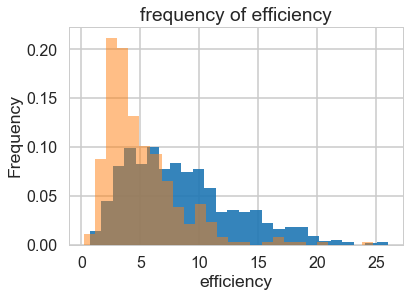

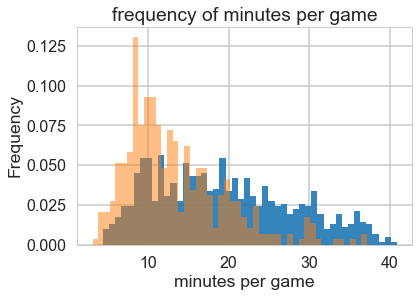

In [4]:
eff_yes = players_yes['EFF'].plot(kind='hist', normed=True, bins=26, alpha=0.9, label='eff_yes')
eff_no = players_no['EFF'].plot(kind='hist', normed=True, bins=26, alpha=0.5, label='eff_no')

plt.xlabel('efficiency')
plt.title('frequency of efficiency')

plt.show()

eff_yes = players_yes['MIN'].plot(kind='hist', normed=True, bins=48, alpha=0.9, label='min_yes')
eff_no = players_no['MIN'].plot(kind='hist', normed=True, bins=48, alpha=0.5, label='min_no')

plt.xlabel('minutes per game')
plt.title('frequency of minutes per game')

plt.show()

#eff_yes = players_yes['GP'].plot(kind='hist', normed=True, bins=41, alpha=0.9, label='gp_yes')
#eff_no = players_no['GP'].plot(kind='hist', normed=True, bins=41, alpha=0.5, label='gp_no')

#plt.xlabel('games played')
#plt.title('frequency of games played')

#plt.show()

Using both logistic regression and KNN, I will evaluate the generated models based on accuracy and decide which algorithm is the best to use for this set of data for classifying NBA rookies.

In [6]:
old_players = players_yes.append(players_no) # all players who were drafted before 2012, will use to train and test
new_players = players_new # new players who were drafted after 2012, will use in the future to see how the model performs

In [34]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(old_players[['EFF', 'MIN']].values, old_players[['TARGET_5Yrs']].values)

# create the logreg classifier
logreg = LogisticRegression()

# fit the classifier to the training data
logreg.fit(X_train, y_train)

# predict the labels of the test set
y_pred = logreg.predict(X_test)

# confusion matrix, classification report, and accuracy score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_pred, y_test))

[[ 39  60]
 [ 24 185]]
             precision    recall  f1-score   support

          0       0.62      0.39      0.48        99
          1       0.76      0.89      0.81       209

avg / total       0.71      0.73      0.71       308

0.727272727273


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
# tuning the model using k-fold cross-validation

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

logreg = LogisticRegression()
score = cv_score(logreg, X_train, y_train)
print(score) # score without regularization

0.701756756757


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

scores = []

# iterate over C values to choose the highest score
for c in Cs:
    logreg = LogisticRegression()
    logreg.C = c
    #score = cv_score(clf, Xlr, ylr)
    scores.append(cv_score(logreg, X_train, y_train))
    
print("The best C-value is ", Cs[scores.index(max(scores))])

The best C-value is  0.1


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
# calculate accuracy on the test data using the C value with the highest score

logreg = LogisticRegression()
logreg.C = Cs[scores.index(max(scores))]
# Fit the model on the trainng data.
logreg.fit(X_train, y_train)
# Print the accuracy from the testing data.
print(accuracy_score(logreg.predict(X_test), y_test))

0.717532467532


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
# estimate logistic regression accuracy using gridsearchcv
logreg = LogisticRegression()
params = {"C":[0.001, 0.1, 1, 10, 100]}
cv = GridSearchCV(logreg, params)
cv.fit(X_train, y_train)

print("C-value chosen by specifying default scoring on GridSearchCV: ", cv.best_params_['C'])
print("Accuracy: ", accuracy_score(cv.predict(X_test), y_test))

# estimate logistic regression accuracy specifying the cv_score
logreg = LogisticRegression()
params = {"C":[0.001, 0.1, 1, 10, 100]}
cv = GridSearchCV(logreg, params, scoring = cv_score)
cv.fit(X_train, y_train)

print("C-value chosen by specifying cv_score on GridSearchCV: ", cv.best_params_['C'])
print("Accuracy: ", accuracy_score(cv.predict(X_test), y_test))

C-value chosen by specifying default scoring on GridSearchCV:  1
Accuracy:  0.727272727273
C-value chosen by specifying cv_score on GridSearchCV:  0.1
Accuracy:  0.717532467532


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y 

It turns out that the logistic regression model that best classifies the players uses K-Fold cross-validation with a score of 0.727272727273.

# The code below is from the logistic regression mini project assigned to us in Springboard.

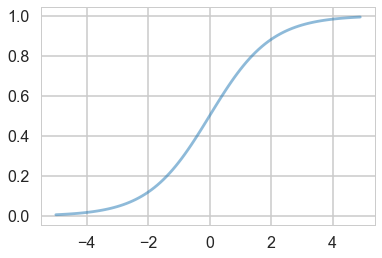

In [39]:
# the code below is set up for classification of the data and supports the math behind how classification is done
# and returns the best classifier to us

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

# we then use the best classifier to fit the entire training set, returning the split data and the trained classifier

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

# sigmoid function for classification

h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [40]:
# for plotting

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

BEST PARAMS {'C': 10}
Accuracy on training data: 0.71
Accuracy on test data:     0.72


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


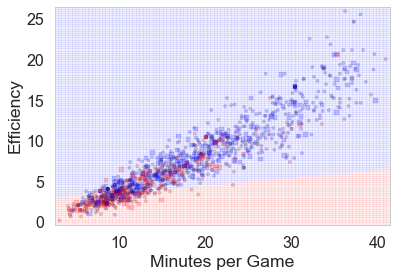

In [41]:
# use do_classify to split data and return the trained classifier

logreg_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           old_players, ['MIN', 'EFF'], 'TARGET_5Yrs',1)

plt.figure()
plt.xlabel("Minutes per Game")
plt.ylabel("Efficiency")
ax = plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, logreg_l, alpha=0.2);

Accuracy for training data and test data were 0.71 and 0.72, respectively. This is not as high of an accuracy that I would have liked but it works well enough to get a general sense of how a rookie's stats lead to their NBA career longevity. Since we are looking at year 1 out of 5, it is difficult to predict the likelihood that they play for 4 more years unless they are a prodigy.

In [42]:
logreg_l.predict_proba(Xtest_l)

array([[ 0.50699583,  0.49300417],
       [ 0.33797991,  0.66202009],
       [ 0.11899483,  0.88100517],
       [ 0.3925651 ,  0.6074349 ],
       [ 0.36236446,  0.63763554],
       [ 0.06913175,  0.93086825],
       [ 0.32786851,  0.67213149],
       [ 0.62892682,  0.37107318],
       [ 0.31309348,  0.68690652],
       [ 0.42942209,  0.57057791],
       [ 0.17813807,  0.82186193],
       [ 0.42551357,  0.57448643],
       [ 0.35574175,  0.64425825],
       [ 0.1506993 ,  0.8493007 ],
       [ 0.46892046,  0.53107954],
       [ 0.01370369,  0.98629631],
       [ 0.56386836,  0.43613164],
       [ 0.49257508,  0.50742492],
       [ 0.41090015,  0.58909985],
       [ 0.56049093,  0.43950907],
       [ 0.25857204,  0.74142796],
       [ 0.48337351,  0.51662649],
       [ 0.38760255,  0.61239745],
       [ 0.56321904,  0.43678096],
       [ 0.02008409,  0.97991591],
       [ 0.07658922,  0.92341078],
       [ 0.01352643,  0.98647357],
       [ 0.58679689,  0.41320311],
       [ 0.11093936,

C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


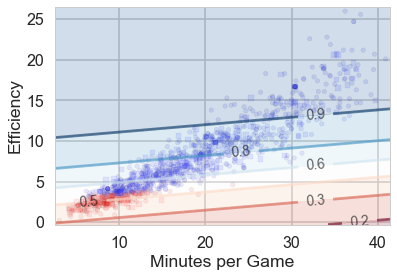

In [43]:
plt.figure()
plt.xlabel("Minutes per Game")
plt.ylabel("Efficiency")
ax = plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, logreg_l, psize=20, alpha=0.1);

What this plot illustrates is the decision boundaries between players who play for 5 years and those who do not play for 5 years. To classify a new player, it checks on which side the player is plotted and then makes a prediction. Given efficiency and minutes per game, what is the probability of playing in the NBA for at least 5 years?

I will now try KNN and compare it with my results above.

C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app


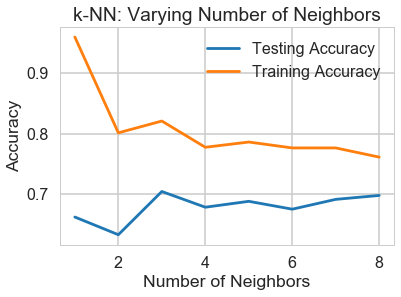

In [44]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(old_players[['EFF', 'MIN']].values, old_players[['TARGET_5Yrs']].values)

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors = k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

The highest accuracy with the exception of overfitting with 1 neighbor is setting the number of neighbors equal to 3.

In [45]:
# Create a k-NN classifier with 3 neighbors: knn
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Print the accuracy
print(knn.score(X_test, y_test))

0.704545454545


C:\Users\jho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


Logistic regression provides a slightly higher accuracy score for classifying the old players with a score of 0.727272727273 than KNN's accuracy score of 0.704545454545.

Logistic regression seemed like the better algorithm to use because it provides a probability of a player playing in the NBA for at least 5 years given their minutes per game and efficiency. However, with KNN, data points are classified based on other data points near them. Players with similar stats will likely have similar outcomes for their career longevity because their production levels on the basketball court are also similar. 

Both classification algorithms perform with about the same accuracy. There isn't a large enough gap between accuracies to convince me that one is more optimal over the other. Running these algorithms again on the same data provides different results and accuracies, sometimes with KNN having the higher accuracy. This makes me wonder if I should use a more complex algorithm, such as SVM, Bayesian methods, or decision trees...